# Disaster Tweets Classification Using Natural Language Processing (NLP)
Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website here.


Competition link : https://www.kaggle.com/c/nlp-getting-started/overview

## Problem Statement:
To classify tweets whether they indicate a disaster or not. - Binary Classification

## Project Planning
1. Import Libraries
2. Load Data
3. Exploratory Data Analysis

## 1. Importing Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', 150)

import seaborn as sns
import matplotlib.pyplot as plt

import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import FreqDist, word_tokenize

import spacy

nlp = spacy.load("en_core_web_sm")

plt.rcParams.update({'font.size': 12})

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2. Load Data

In [3]:
# Load data
df_train = pd.read_csv("datasets/train.csv")
df_test = pd.read_csv("datasets/test.csv")
sub_sample = pd.read_csv("datasets/sample_submission.csv")

print (df_train.shape, df_test.shape, sub_sample.shape)

(7613, 5) (3263, 4) (3263, 2)


In [4]:
print('df_train data shape: ',df_train.shape)
print('df_test data shape: ',df_test.shape)

df_train data shape:  (7613, 5)
df_test data shape:  (3263, 4)


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## 3. Exploratory Data Analysis

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
print('Null values from df_train data')
null_df_train = df_train.isnull().sum(axis=0)
print(null_df_train)

print('\n\nNull values from df_test data')
null_df_test = df_test.isnull().sum(axis=0)
print(null_df_test)

Null values from df_train data
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


Null values from df_test data
id             0
keyword       26
location    1105
text           0
dtype: int64


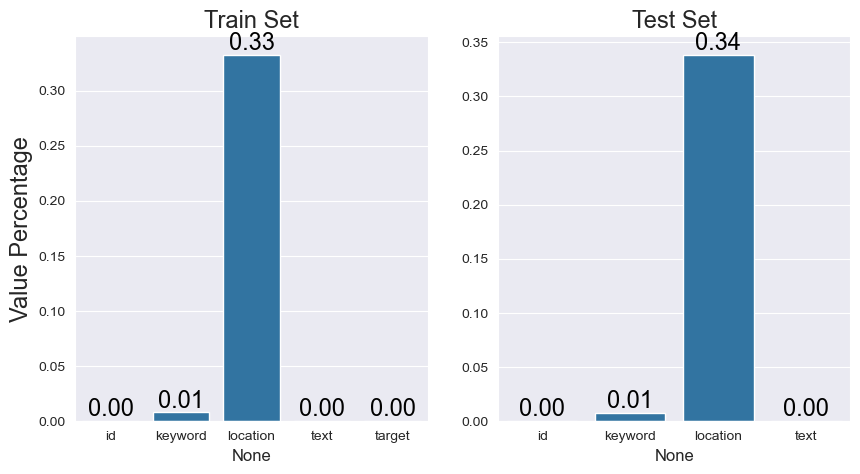

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

sns.barplot(x = null_df_train.index, y = null_df_train.values/df_train.shape[0], ax=ax[0])
sns.barplot(x = null_df_test.index, y = null_df_test.values/df_test.shape[0], ax=ax[1])

ax[0].set_ylabel('Value Percentage', size=17)
ax[0].set_title('Train Set', fontsize=17)
ax[1].set_title('Test Set', fontsize=17)

for ax in ax:
  ax.tick_params(labelsize=10)
  for p in ax.patches:
      ax.annotate('{:.2f}'.format(p.get_height()),
                  (p.get_x() + 0.4, p.get_height()),
                  ha='center', va='bottom', color='black', size=17)
plt.show();

Very similar null value distribution of Train and Test data. It might indicate Train and test data are good samples from the population.

Null values in 'Keyword' column is imputed with 'None' value first. As keyword is an important feature for summarizing the disaster, it can be filled with a word from tweet text. This treatment can be done during Preprocessing.  
Need to explore 'location' field to impute null values.

Lets explore the 'keyword' column 

target
0    0.57034
1    0.42966
Name: id, dtype: float64


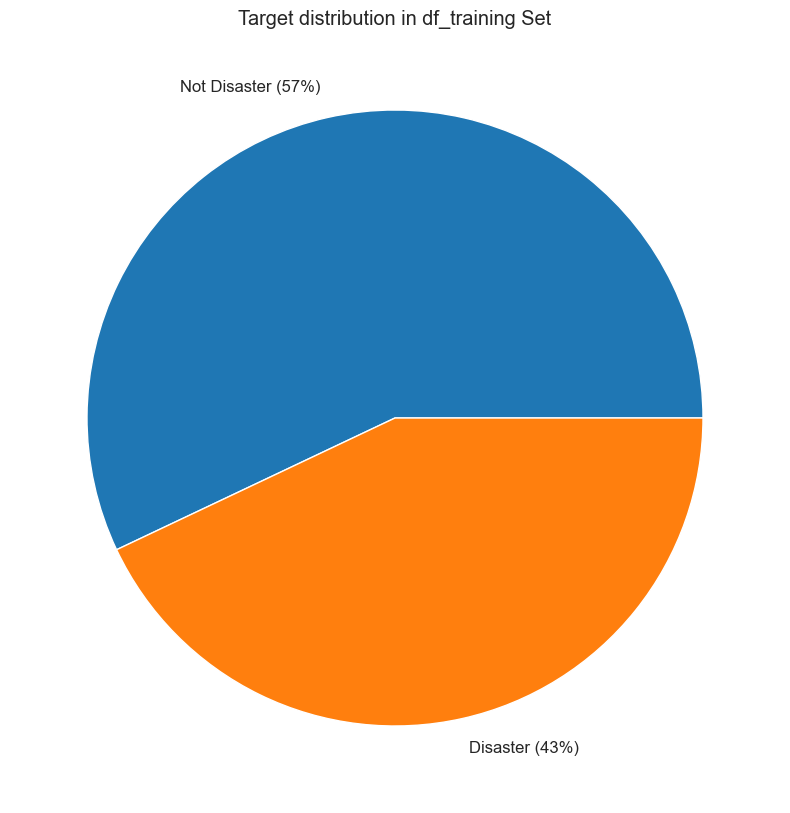

In [10]:
# Proportion of Target Classes
class_count = df_train.groupby('target').count()['id']/df_train.shape[0]
print(class_count)

plt.figure(figsize = (10,10));
df_train.groupby('target').count()['id'].plot(kind='pie', 
                                          labels=['Not Disaster (57%)', 'Disaster (43%)'],
                                          title='Target distribution in df_training Set',
                                          ylabel='');

In [12]:
df_train['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [13]:
df_train_temp = df_train['keyword'].value_counts()
df_train_temp[df_train_temp.values < 30]

annihilation             29
bombing                  29
obliteration             29
sirens                   29
snowstorm                29
desolate                 29
seismic                  29
first%20responders       29
rubble                   28
demolished               28
deluged                  27
volcano                  27
battle                   26
bush%20fires             25
war%20zone               24
rescue                   22
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, dtype: int64

There is a '%20' character in the text, this needs to treated with space.

### Treating 'keyword' column

In [14]:
# Fill missing values with 'None'
df_train['keyword'] = df_train['keyword'].fillna(f'None')
df_test['keyword'] = df_test['keyword'].fillna(f'None')

# fix '20%' typo in 'keyword' column
df_train['keyword'] = df_train['keyword'].apply(lambda x: re.sub('%20', ' ', x))
df_test['keyword'] = df_test['keyword'].apply(lambda x: re.sub('%20', ' ', x))

In [15]:
# Filling 'None' values in 'keyword' column with a word from 'keyword' column values, which is present in that text.
# For each row with 'keyword' = None
#   Check corresponding 'text' for an existing 'keyword' value
#       If found, replace 'None' with that 'keyword' value
no_keyword = df_train['keyword'] == 'None'
keywords = np.unique(df_train[~no_keyword]['keyword'].to_numpy())

for df in [df_train, df_test]:
    for i in range(len(df)):
        if df.loc[i, 'keyword'] == 'None':
            for k in keywords:
                if k in df.loc[i, 'text'].lower():
                    df.loc[i, 'keyword'] = k
                    break

In [16]:
print('Number of missing values left:')
print('For Train set:', df_train[df_train['keyword'] == 'None'].shape[0])
print('For Test set:', df_test[df_test['keyword'] == 'None'].shape[0])

pd.concat([df_train[df_train['keyword'] == 'None']['text'], df_test[df_test['keyword'] == 'None']['text']])

Number of missing values left:
For Train set: 16
For Test set: 9


15                                                              What's up man?
16                                                               I love fruits
17                                                            Summer is lovely
18                                                           My car is so fast
19                                                What a goooooooaaaaaal!!!!!!
20                                                      this is ridiculous....
21                                                           London is cool ;)
22                                                                 Love skiing
23                                                       What a wonderful day!
24                                                                    LOOOOOOL
25                                              No way...I can't eat that shit
26                                                       Was in NYC last week!
27                                                  

These are the final 'text' columns values having 'None' value for 'keyword' column. They don't have any significant keyword, so left as they are, these rows have 'keyword'= None

In [17]:
# Fill missing values with 'None'
df_train['location'] = df_train['location'].fillna(f'None')
df_test['location'] = df_test['location'].fillna(f'None')

In [18]:
df_train.isna().sum()
df_test.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

id          0
keyword     0
location    0
text        0
dtype: int64

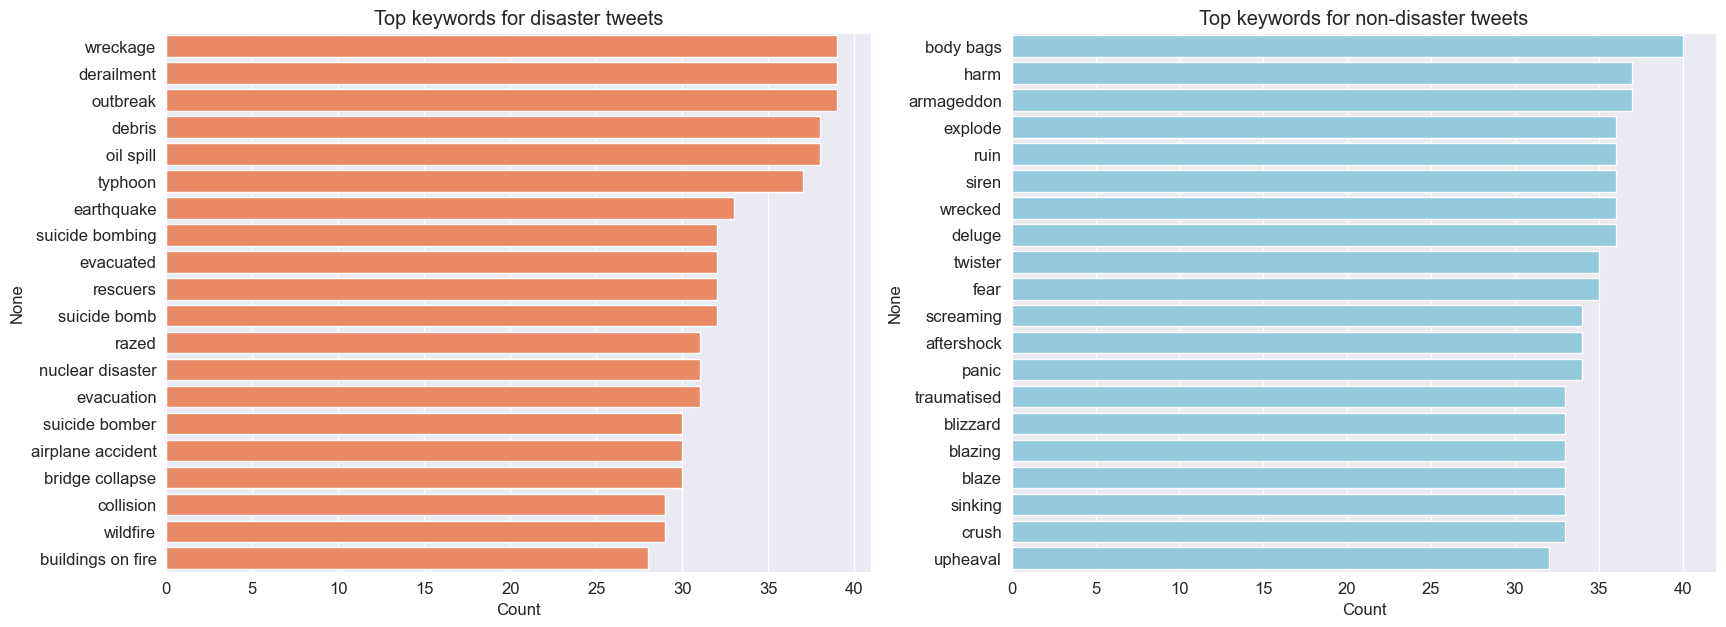

In [19]:
# Top 20 keywords for each class

disaster = df_train[df_train['target']==1]['keyword'].value_counts().head(20)
non_disaster = df_train[df_train['target']==0]['keyword'].value_counts().head(20)

fig, ax = plt.subplots(1,2, figsize=(20,7))

ax[0].set_title('Top keywords for disaster tweets')
ax[0].set_xlabel('Count')
sns.barplot(x = disaster, y = disaster.index, color='coral', ax=ax[0] )

ax[1].set_title('Top keywords for non-disaster tweets')
ax[1].set_xlabel('Count')
sns.barplot(x = non_disaster, y = non_disaster.index, color='skyblue',  ax=ax[1]);

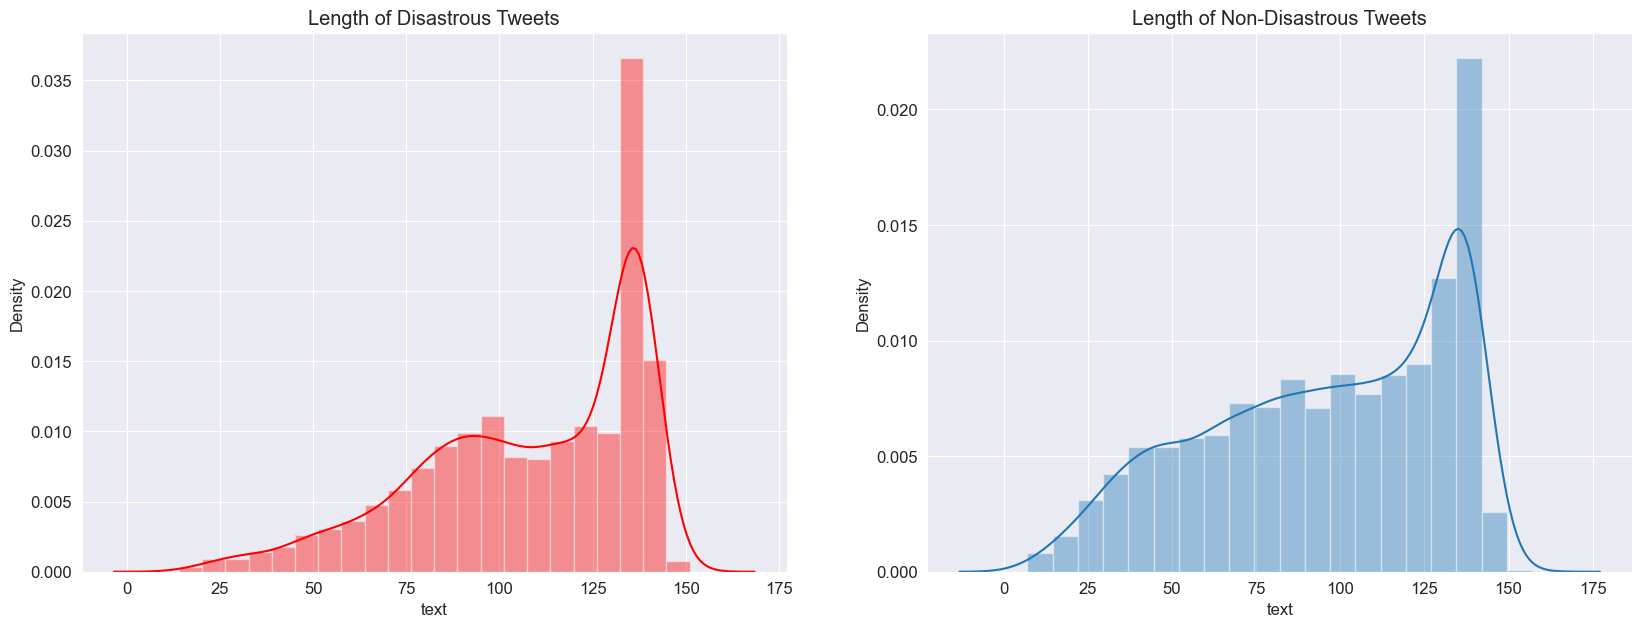

In [20]:
# Tweet Length for both classes

pos_tw_len = df_train[df_train['target'] == 1]['text'].str.len()
neg_tw_len = df_train[df_train['target'] == 0]['text'].str.len()

fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].set_xlabel(' ')
ax[0].set_title('Length of Disastrous Tweets')
sns.distplot(pos_tw_len, label='Disaster Tweet length', ax=ax[0], color='red')

ax[1].set_xlabel(' ')
ax[1].set_title('Length of Non-Disastrous Tweets')
sns.distplot(neg_tw_len, label='Non-Disaster Tweet length', ax=ax[1]);

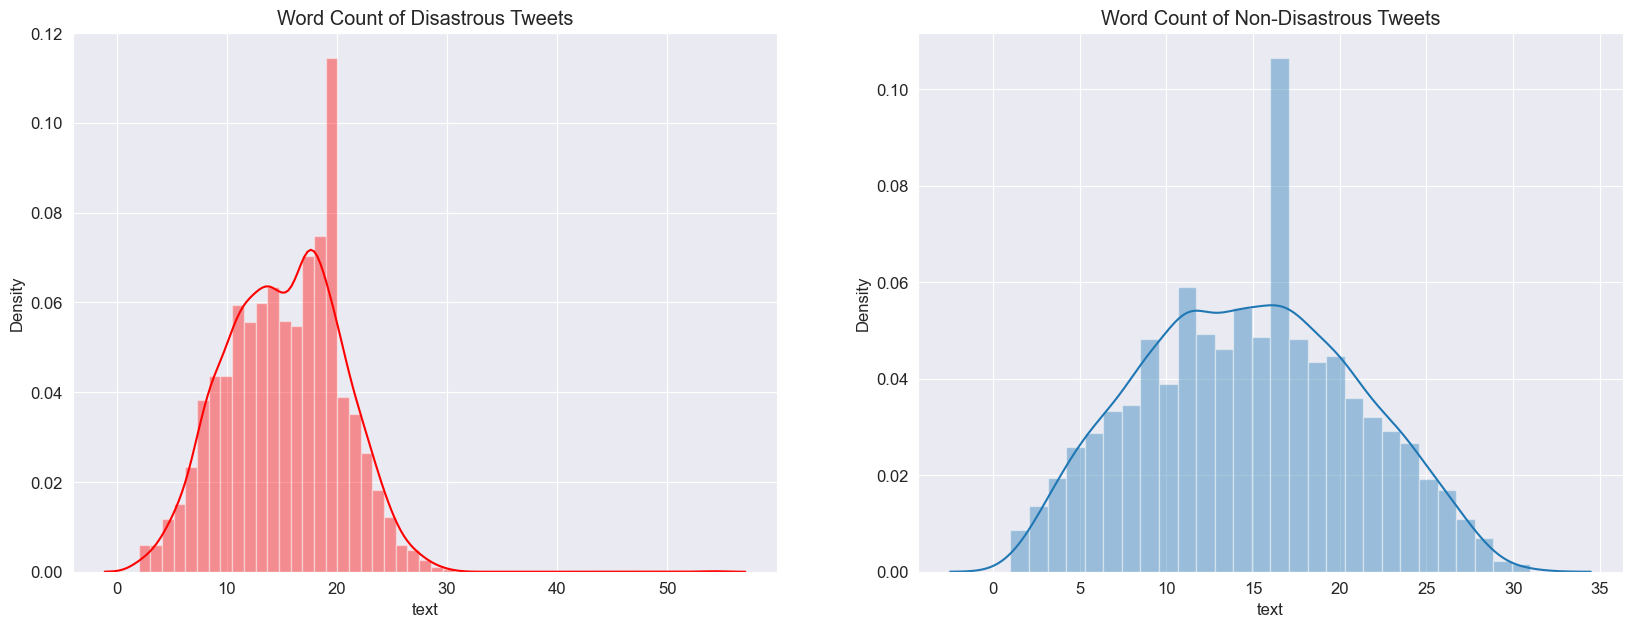

In [21]:
# Word Count of Tweets in both classes
pos_tw_len = df_train[df_train['target'] == 1]['text'].apply(lambda x: len(x.split(' ')))
neg_tw_len = df_train[df_train['target'] == 0]['text'].apply(lambda x: len(x.split(' ')))

fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].set_xlabel(' ')
ax[0].set_title('Word Count of Disastrous Tweets')
sns.distplot(pos_tw_len, label='Disaster Tweet length', ax=ax[0], color='red')

ax[1].set_xlabel(' ')
ax[1].set_title('Word Count of Non-Disastrous Tweets')
sns.distplot(neg_tw_len, label='Non-Disaster Tweet length', ax=ax[1]);

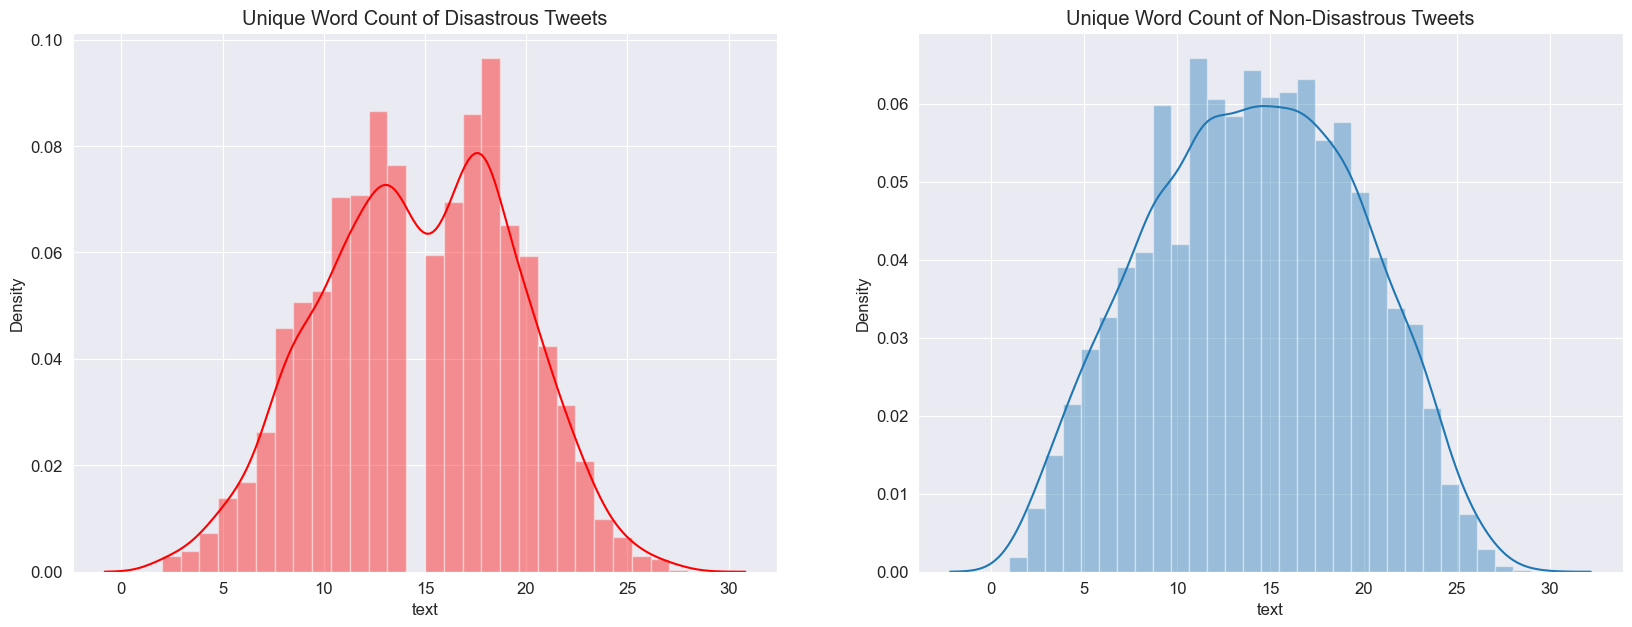

In [22]:
# Number of Unique words in Tweets in both classes
pos_tw_len = df_train[df_train['target'] == 1]['text'].apply(lambda x: len(set(x.split(' '))))
neg_tw_len = df_train[df_train['target'] == 0]['text'].apply(lambda x: len(set(x.split(' '))))

fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].set_xlabel(' ')
ax[0].set_title('Unique Word Count of Disastrous Tweets')
sns.distplot(pos_tw_len, label='Disaster Tweet length', ax=ax[0], color='red')

ax[1].set_xlabel(' ')
ax[1].set_title('Unique Word Count of Non-Disastrous Tweets')
sns.distplot(neg_tw_len, label='Non-Disaster Tweet length', ax=ax[1]);

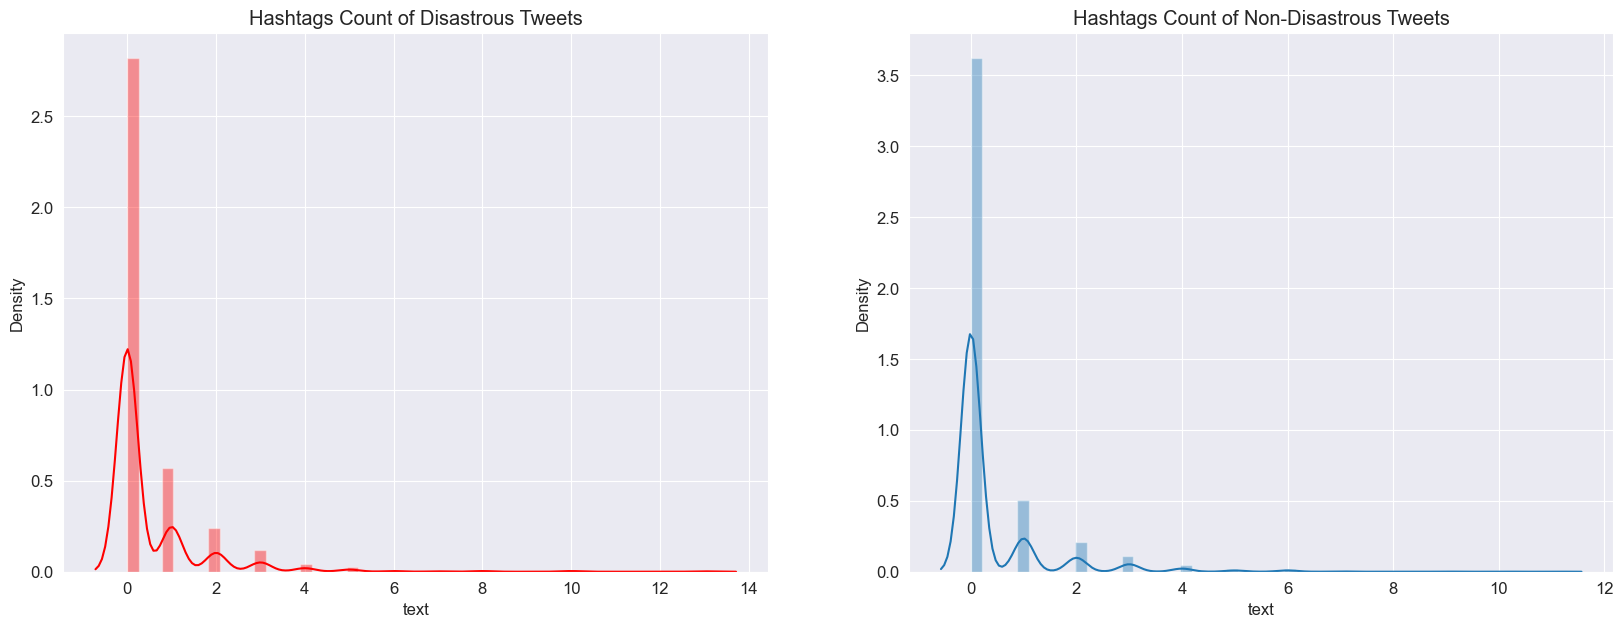

In [23]:
# Number of occurances of # hashtag in a tweet in both classes
pos_tw = df_train[df_train['target'] == 1]['text'].apply(lambda x: x.count('#'))
neg_tw = df_train[df_train['target'] == 0]['text'].apply(lambda x: x.count('#'))

fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].set_xlabel(' ')
ax[0].set_title('Hashtags Count of Disastrous Tweets')
sns.distplot(pos_tw, label='Disaster Tweet length', ax=ax[0], color='red')

ax[1].set_xlabel(' ')
ax[1].set_title('Hashtags Count of Non-Disastrous Tweets')
sns.distplot(neg_tw, label='Non-Disaster Tweet length', ax=ax[1]);

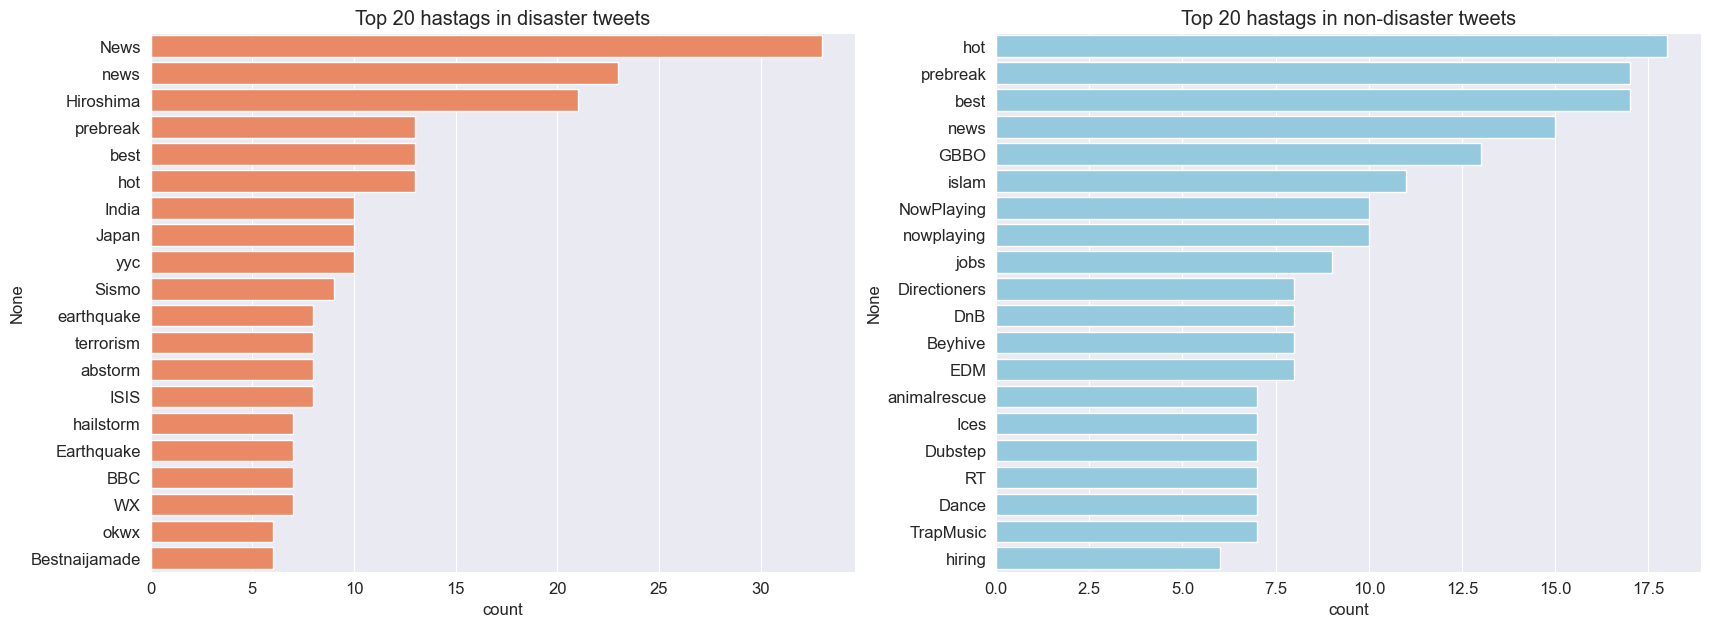

In [24]:
# Top 20 Hastags for each class
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'None'
df_train['hashtags'] = df_train['text'].apply(lambda x: find_hashtags(x))
df_test['hashtags'] = df_test['text'].apply(lambda x: find_hashtags(x))

fig, ax = plt.subplots(1,2, figsize=(20,7))


freq_d = FreqDist(w for w in word_tokenize(' '.join(df_train.loc[df_train['target']==1, 'hashtags'])) if w != 'None')
df_d = pd.DataFrame.from_dict(freq_d, orient='index', columns=['count'])
hashtag_d = df_d.sort_values('count', ascending=False).head(20)
sns.barplot(x = hashtag_d['count'], y = hashtag_d.index, color='coral', ax = ax[0])
ax[0].set_title('Top 20 hastags in disaster tweets')

freq_nd = FreqDist(w for w in word_tokenize(' '.join(df_train.loc[df_train['target']==0, 'hashtags'])) if w != 'None')
df_nd = pd.DataFrame.from_dict(freq_nd, orient='index', columns=['count'])
hashtag_nd = df_nd.sort_values('count', ascending=False).head(20)
sns.barplot(x = hashtag_nd['count'], y = hashtag_nd.index, ax = ax[1], color='skyblue')
ax[1].set_title('Top 20 hastags in non-disaster tweets')

plt.show();

In [24]:
# df_train[df_train['location'] != 'None']['location'].value_counts().plot(kind='pie')